In [31]:
import csv
import lzstring
from collections import namedtuple, Counter
import json
from memoize import memoize
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import sys
import json

In [32]:
csv.field_size_limit(sys.maxsize)

# [num unique urls, num unique urls typed, total visits, total typed, first visit time, last visit time]
domaininfo = namedtuple('domaininfo', ['num_unique_urls', 'num_unique_urls_typed', 'total_visits', 'total_typed', 'first_visit_time', 'last_visit_time'])

decompressFromEncodedURIComponent = lzstring.LZString().decompressFromEncodedURIComponent

#filepath = 'difficultyselectionexp_may31_11am.csv'
filepath = 'data/JUL17.csv'
reader = csv.DictReader(open(filepath))

def extract_domain_visit_info(domain_visit_info_compressed):
  domain_visit_info = json.loads(decompressFromEncodedURIComponent(domain_visit_info_compressed))
  output = {}
  for k,v in domain_visit_info.items():
    linedata = domaininfo(*v)
    output[k] = linedata
  return output

alldata = []

for alldata_item in reader:
  if alldata_item['selected_difficulty'] not in ['nothing', 'easy', 'medium', 'hard']:
    continue
  if alldata_item['domain_visit_info_compressed'] == None or len(alldata_item['domain_visit_info_compressed']) == 0:
    continue
  alldata_item['domain_visit_info'] = extract_domain_visit_info(alldata_item['domain_visit_info_compressed'])
  alldata.append(alldata_item)


In [33]:
#np.random.shuffle(alldata)
training_data = alldata[:round(len(alldata)*0.8)]
test_data = alldata[round(len(alldata)*0.8):]
print(len(training_data))
print(len(test_data))

605
151


In [34]:
def extract_labels_alldata(data):
  return np.array([line['selected_difficulty'] for line in data])

@memoize
def get_most_common_label():
  label_to_count = Counter()
  for line in training_data:
    label = line['selected_difficulty']
    label_to_count[label] += 1
  sorted_by_count = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)
  return sorted_by_count[0][0]

@memoize
def get_most_visited_domains():
  domain_to_num_visits = Counter()
  for line in training_data:
    domain_visit_info = line['domain_visit_info']
    for domain,info in domain_visit_info.items():
      domain_to_num_visits[domain] += info.total_visits
  sorted_by_num_visits = sorted(domain_to_num_visits.items(), key=lambda x: x[1], reverse=True)
  return [x[0] for x in sorted_by_num_visits[:100]]

cnt = 0
@memoize
def get_most_common_domains():
  domain_to_num_visits = Counter()
  for line in training_data:
    domain_visit_info = line['domain_visit_info']
    for domain,info in domain_visit_info.items():
      domain_to_num_visits[domain] += 1
  sorted_by_num_visits = sorted(domain_to_num_visits.items(), key=lambda x: x[1], reverse=True)
  return [x[0] for x in sorted_by_num_visits[:100]]

def get_all_domains():
  domain_to_num_visits = Counter()
  for line in training_data:
    domain_visit_info = line['domain_visit_info']
    for domain,info in domain_visit_info.items():
      domain_to_num_visits[domain] += 1
  sorted_by_num_visits = sorted(domain_to_num_visits.items(), key=lambda x: x[1], reverse=True)
  return [x[0] for x in sorted_by_num_visits]



def get_num_visits_for_domain(domain_visit_info, domain):
  info = domain_visit_info.get(domain, None)
  if info != None:
    return info.total_visits
  return 0

def get_productivity():
    with open ('domain_to_productivity.json') as json_file:
        data = json.load(json_file)
        return data

domain_to_productivity = get_productivity()

def get_productivity_domain(domain):
    if domain in domain_to_productivity.keys():
        return domain_to_productivity[domain]
    domain2 = domain.split('.')
    final = 'www.' + domain2[len(domain2) - 2] + '.com'
    if final in domain_to_productivity.keys():
        return domain_to_productivity[final]
    return None

def extract_features_for_user(domain_visit_info):
  cnt = 0
  domains = get_all_domains()
  final_features = [0, 0, 0, 0, 0];
  for x in domains:
        if get_productivity_domain(x) != None:
            final_features[get_productivity_domain(x) + 2] += get_num_visits_for_domain(domain_visit_info, x)
    
  #np.array([get_num_visits_for_domain(domain_visit_info, x) for x in domains])
  #if np.sum(final_features) >= 1:
    #final_features = np.divide(final_features, np.sum(final_features))
  return final_features


def extract_features_alldata(data):
  output = []
  for line in data:
    domain_visit_info = line['domain_visit_info']
    features = extract_features_for_user(domain_visit_info)
    output.append(features)
  return np.array(output)


In [35]:
def get_percent_correct(predicted_labels, actual_labels):
  if len(predicted_labels) != len(actual_labels):
    raise 'need predicted and actual labels to have same lengths'
  total = len(actual_labels)
  correct = 0
  for p,a in zip(predicted_labels, actual_labels):
    if p == a:
      correct += 1
  return correct / total

def test_baseline_classifier():
  most_common_label = get_most_common_label()
  predictions = [most_common_label for line in test_data]
  actual = extract_labels_alldata(test_data)
  percent_correct = get_percent_correct(predictions, actual)
  print('baseline classifier accuracy:', percent_correct)

def test_classifier(clf,features_test, actual, str=None):
  #actual = extract_labels_alldata(test_data)
  #features_test = extract_features_alldata(test_data)
  predictions = clf.predict(features_test)
  percent_correct = get_percent_correct(predictions, actual)
  return percent_correct

def training_error_classifier(clf, str=None):
  actual = extract_labels_alldata(training_data)
  features_train = extract_features_alldata(training_data)
  predictions = clf.predict(features_train)
  percent_correct = get_percent_correct(predictions, actual)
  print(str + ' classifier training accuracy:', round(percent_correct, 2))

def to_int_categorical(dt):
  # {'easy', 'hard', 'medium', 'nothing'}
  cat_dt = []
  for item in dt:
    if item == 'nothing':
      cat_dt.append(0)
    elif item == 'easy':
      cat_dt.append(1)
    elif item == 'medium':
      cat_dt.append(2)
    else:
      cat_dt.append(3)
  return np.array(cat_dt)
    
test_baseline_classifier()

baseline classifier accuracy: 0.5231788079470199


In [36]:
labels_train = extract_labels_alldata(training_data)
features_train = extract_features_alldata(training_data)
labels_test = extract_labels_alldata(test_data)
features_test = extract_features_alldata(test_data)

In [37]:
def classifiers():
    gnb = GaussianNB()
    gnb.fit(features_train, labels_train)
    acc = test_classifier(gnb, features_test, labels_test, 'GNB')
    return acc

In [38]:
print (classifiers())

0.37748344370860926


In [39]:
labels_train2 = labels_train
features_train2 = features_train
labels_test2 = labels_test
features_test2 = features_test

print (len(features_test2))

151


In [40]:
cache_GNB = []
training_size = []
num = 300
for i in range(num):
    labels_train = labels_train2[: max(3, round(len(labels_train2)*((i + 1) / num)))]
    features_train = features_train2[: max(3, round(len(features_train2)*((i + 1) / num)))]
    labels_test = labels_test2[: max(3, round(len(labels_test2)*((i + 1) / num)))]
    features_test = features_test2[: max(3, round(len(features_test2)*((i + 1) / num)))]
   
    result = classifiers()
   
    cache_GNB.append(result)
    training_size.append(len(labels_train))

print (cache_GNB)
print (training_size)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.25, 0.25, 0.2, 0.2, 0.3333333333333333, 0.3333333333333333, 0.2857142857142857, 0.14285714285714285, 0.125, 0.125, 0.2222222222222222, 0.2222222222222222, 0.2, 0.2, 0.18181818181818182, 0.18181818181818182, 0.16666666666666666, 0.16666666666666666, 0.15384615384615385, 0.15384615384615385, 0.21428571428571427, 0.21428571428571427, 0.2, 0.2, 0.25, 0.25, 0.23529411764705882, 0.23529411764705882, 0.2222222222222222, 0.2222222222222222, 0.21052631578947367, 0.21052631578947367, 0.2, 0.25, 0.2857142857142857, 0.3333333333333333, 0.3181818181818182, 0.36363636363636365, 0.34782608695652173, 0.34782608695652173, 0.3333333333333333, 0.3333333333333333, 0.32, 0.32, 0.3076923076923077, 0.3076923076923077, 0.2962962962962963, 0.48148148148148145, 0.4642857142857143, 0.4642857142857143, 0.4482758620689655, 0.4482758620689655, 0.43333333333333335, 0.43333333333333335, 0.41935483870967744, 0.45161290322580644, 0.46875, 0.46875, 0.45454545454545453, 0.4

In [41]:
import matplotlib.pyplot as plt

learning curve for GNB:


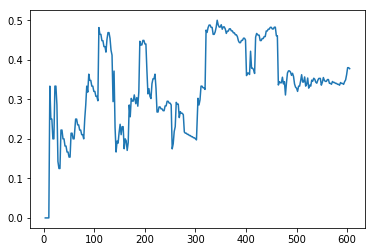

In [42]:
print ("learning curve for GNB:")

plt.plot(training_size, cache_GNB)

In [43]:
print (len(features_train))
print (len(features_test))

605
151


In [44]:
def classifiers_confusion():
    gnb = GaussianNB()
    gnb.fit(features_train, labels_train)
    acc = test_classifier(gnb, features_test, labels_test, 'GNB')
    predicted = gnb.predict(features_test)
    confusion = {'nothing': {'nothing': 0, 'easy': 0, 'medium': 0, 'hard': 0},
                 'easy': {'nothing': 0, 'easy': 0, 'medium': 0, 'hard': 0},
                 'medium': {'nothing': 0, 'easy': 0, 'medium': 0, 'hard': 0}, 
                 'hard': {'nothing': 0, 'easy': 0, 'medium': 0, 'hard': 0}}
    
    classes = ['nothing', 'easy', 'medium', 'hard']
    for i in range(len(features_test)):
        confusion[predicted[i]][labels_test[i]] += 1
        
        
    print ("GNB")
    for i in classes:
        print (i)
        print (confusion[i])
    return 

In [45]:
classifiers_confusion()

GNB
nothing
{'nothing': 8, 'easy': 24, 'medium': 13, 'hard': 5}
easy
{'nothing': 8, 'easy': 45, 'medium': 20, 'hard': 9}
medium
{'nothing': 0, 'easy': 6, 'medium': 4, 'hard': 0}
hard
{'nothing': 1, 'easy': 4, 'medium': 4, 'hard': 0}
